## Mini PJT

- 해당 데이터를 고객 단위로 묶어야 합니다.


- 데이터를 정제해서, 월별/고객별로 재정렬이 필요합니다. (aggregation)


- row가 고객별 데이터로 묶이고 난 다음, 고객들을 유형별로 나눠봅니다.


- 여러 가지 클러스터링 알고리즘을 사용하여, 결과를 테스트해봅니다.


- 클러스터링을 위한 전처리부터, 평가까지 모든 항목을 하나하나 살펴보면서 데이터를 뜯어봅니다.

### Data Description

Source : https://www.kaggle.com/c/instacart-market-basket-analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

warnings.simplefilter('ignore')

### 1. 데이터 불러오기 

In [5]:
# instacart 데이터를 모두 불러옵니다.

base_path = './customer_data/instacart-market-basket-analysis/'

aisles_df = pd.read_csv(base_path + 'aisles.csv')
departments_df = pd.read_csv(base_path + 'departments.csv')
order_products__prior_df = pd.read_csv(base_path + 'order_products__prior.csv')
order_products__train_df = pd.read_csv(base_path + 'order_products__train.csv')
orders_df = pd.read_csv(base_path + 'orders.csv')
products_df = pd.read_csv(base_path + 'products.csv')
sample_submission_df = pd.read_csv(base_path + 'sample_submission.csv')

In [6]:
aisles_df.shape, \
departments_df.shape, \
order_products__prior_df.shape, \
order_products__train_df.shape, \
orders_df.shape, \
products_df.shape, \
sample_submission_df.shape

((134, 2),
 (21, 2),
 (32434489, 4),
 (1384617, 4),
 (3421083, 7),
 (49688, 4),
 (75000, 2))

In [13]:
products_df

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [ ]:
## 고객의 구매 패턴을 어떤식으로 정의할 것인가??

In [16]:
# 불러온 모든 테이블을 합칩니다.
prior_sample = order_products__prior_df[:10000]
prior_sample

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
9995,1022,21903,1,1
9996,1022,38689,2,1
9997,1022,30391,3,1
9998,1022,18670,4,1


In [23]:
temp = pd.merge(orders_df, prior_sample, on='order_id')
temp = pd.merge(temp, products_df, on='product_id')
temp = pd.merge(temp, aisles_df, on = 'aisle_id')
temp = pd.merge(temp, departments_df, on='department_id')
temp

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,40,382,prior,29,1,15,23.0,10070,1,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
1,235,58701,prior,20,5,9,9.0,10070,7,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
2,581,76141,prior,3,6,17,7.0,10070,3,0,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
3,649,135836,prior,1,4,7,NaN,10070,1,0,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
4,40,382,prior,29,1,15,23.0,34866,4,1,Chocolate Milk 1% Milkfat,84,16,milk,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,152,103040,prior,12,1,10,7.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9996,959,119941,prior,2,6,13,21.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9997,400,180454,prior,32,0,8,8.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9998,18,118860,prior,3,4,20,6.0,1000,3,0,Apricots,18,10,bulk dried fruits vegetables,bulk


### 2. EDA

In [25]:
# 10만개의 거래내역에 대해서 각 물품을 얼마나 샀을까?
temp['user_id'].value_counts() ## 972면의 고객.

149156    46
150739    45
11335     44
119437    39
87889     38
          ..
36916      1
99415      1
160167     1
15161      1
154766     1
Name: user_id, Length: 972, dtype: int64

In [26]:
temp['product_name'].value_counts()

Banana                               156
Bag of Organic Bananas               119
Organic Strawberries                  73
Organic Baby Spinach                  70
Organic Hass Avocado                  68
                                    ... 
Organic Bunch Arugula                  1
Russet Potatoes                        1
Organic Whole Crimini Mushrooms        1
Yukon Gold Potatoes                    1
Organic Short Brown Sprouted Rice      1
Name: product_name, Length: 4511, dtype: int64

In [27]:
temp['aisle'].value_counts()

fresh fruits                    1128
fresh vegetables                1076
packaged vegetables fruits       514
yogurt                           395
packaged cheese                  313
                                ... 
first aid                          2
beauty                             1
eye ear care                       1
skin care                          1
bulk grains rice dried goods       1
Name: aisle, Length: 133, dtype: int64

In [28]:
temp['department'].value_counts()

produce            2913
dairy eggs         1647
snacks              862
beverages           801
frozen              746
pantry              598
canned goods        362
bakery              354
deli                319
dry goods pasta     255
household           249
breakfast           238
meat seafood        225
babies              131
personal care       125
international        86
pets                 28
alcohol              27
missing              15
other                13
bulk                  6
Name: department, dtype: int64

In [29]:
temp['order_dow'].value_counts()

1    2135
0    1916
5    1346
6    1333
2    1324
3    1081
4     865
Name: order_dow, dtype: int64

In [30]:
temp['order_hour_of_day'].value_counts()

12    903
13    821
9     818
16    815
10    813
11    793
15    775
17    771
14    706
8     601
18    546
20    373
19    335
7     231
22    175
21    172
23    134
6      95
0      76
1      26
4      16
2       5
Name: order_hour_of_day, dtype: int64

### 3. 데이터 전처리

- 데이터를 transaction 단위로 변경합니다.

- 각자의 방법대로 데이터의 단위를 정해봅시다.


> User 단위로 어떤 물품을 구매했는지의 정보만 가지는 feature vector로 변환한다. e.g. pd.crosstab, CountVectorizer

In [34]:
# transaction -> user-level 단위로 변경하고, User당 정보로 변환하는 과정까지 마무리합니다.
# 1. Department 2. aisle 3. Product_name

X = pd.crosstab(index = temp['user_id'], columns = temp['department'])
X


department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,1,0,0,2,0
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1059,0,0,3,0,3,0,0,8,0,0,...,0,1,2,0,0,2,0,0,8,2
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0


### 4. 클러스터링 모델 적용하기

- 사용하는 클러스터링 모델은 KMeans로 합니다.

(원하시면 AgglomerativeClustering, DBSCAN, SpectralClustering을 사용해보셔도 됩니다. 단, 시간이 매우매우 오래 걸릴수 있으니 주의하세요..)

**[K-Means]**

- Elbow method를 이용하여 최적의 K값을 찾아보세요.


- sparse한 특징을 가지는 데이터를 클러스터링 하기 위해서는 어떤 기법을 사용해야 할까요?


- 클러스터링 결과를 시각화해보고, 실루엣 지수도 계산해봅시다.

In [35]:
# data setting
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,1,0,0,2,0
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1059,0,0,3,0,3,0,0,8,0,0,...,0,1,2,0,0,2,0,0,8,2
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0


In [37]:
# tSNE : 시각화용도의 차원감소 기법. (2차원으로 변환해주는 기법)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X)
tsne_data

array([[ 19.359869 ,  -9.804691 ],
       [-10.483668 , -24.387121 ],
       [ 28.131254 , -18.492928 ],
       ...,
       [  5.816999 ,  -9.006813 ],
       [ 22.229362 ,  -3.3166332],
       [-10.9907055,   1.3168215]], dtype=float32)

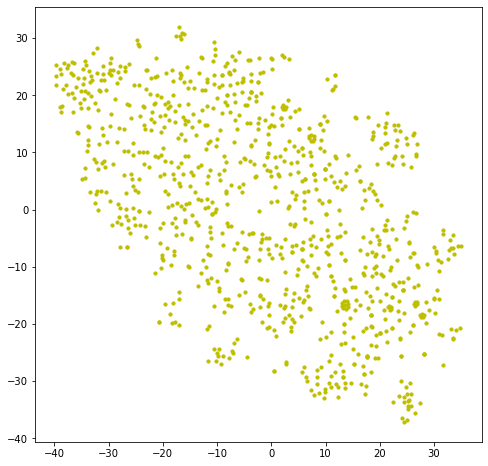

In [38]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c='y')
plt.show()

In [ ]:
# elbow method


In [50]:
# K-means를 돌려봅시다.

#1. K-Means
#2. Hierarchical Agglomerative Clustering
#3. DBSCAN
#4. Spectral Clustering


from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

model =KMeans(n_clusters=4)
model_2 = KMeans(n_clusters=2)
pred = model.fit_predict(X)
pred_2 = model_2.fit_predict(X)
print('Silhouette Score : %.4f' % silhouette_score(X, pred))

Silhouette Score : 0.1914


In [43]:
## elbow method

sse = []
silhouette = []

for K in range(2, 11):
    model = KMeans(n_clusters=K)
    pred = model.fit_predict(X)
    sse.append(model.inertia_) ## SSE
    silhouette.append(silhouette_score(X, pred))

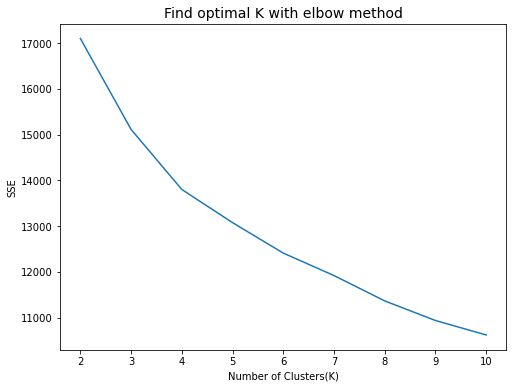

In [45]:
# 최적의 K는 어떻게 구할까요?
# Elbow method : 정해진 K에 대해서 SSE를 계산한 다음, SSE가 가장 많이 꺾이는 K(elbow)가 optimal K라고 판단하는 방법.

plt.figure(figsize=(8, 6))
plt.title("Find optimal K with elbow method", fontsize=14)
plt.xlabel("Number of Clusters(K)", fontsize=10)
plt.ylabel("SSE", fontsize=10)
plt.plot(range(2, 11), sse)
plt.show()

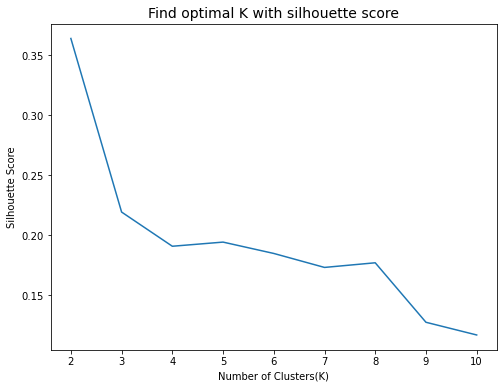

In [47]:
# Silhouette score : 같은 클러스터에 속하는 데이터중 가장 먼 데이터와의 거리와 다른 클러스터에 속하는 데이터 중 가장 가까운 데이터와의 거리 비율을 계산한 지표. [-1, 1]
# Reference : https://en.wikipedia.org/wiki/Silhouette_(clustering)

plt.figure(figsize=(8, 6))
plt.title("Find optimal K with silhouette score", fontsize=14)
plt.xlabel("Number of Clusters(K)", fontsize=10)
plt.ylabel("Silhouette Score", fontsize=10)
plt.plot(range(2, 11), silhouette)
plt.show()

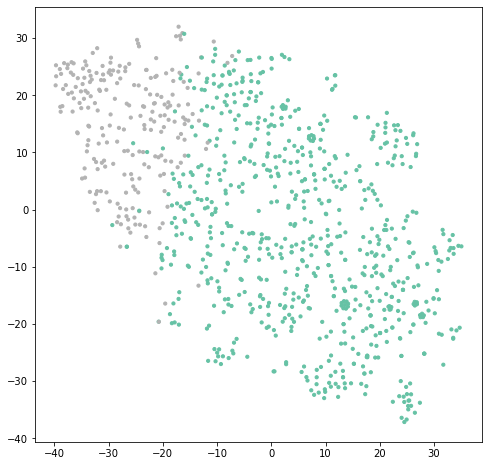

In [51]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c=pred_2, cmap="Set2")
plt.show()

In [65]:
# sse summary

X['cluster_label'] = pred_2
X['Cluster_label'] = pred

In [66]:
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,cluster_label,Cluster_label
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,2
503,0,0,0,0,1,0,2,1,0,0,...,1,0,0,1,0,0,2,0,0,2
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,2
1059,0,0,3,0,3,0,0,8,0,0,...,2,0,0,2,0,0,8,2,1,0
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,2,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,4,1,0,3
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,1,0,0,2


In [67]:
group_1 = X[X['Cluster_label'] == 0]
group_2 = X[X['Cluster_label'] == 1]
group_3 = X[X['Cluster_label'] == 2]
group_4 = X[X['Cluster_label'] == 3]

In [68]:
group_1.shape, group_2.shape, group_3.shape, group_4.shape

((112, 23), (82, 23), (493, 23), (285, 23))

In [69]:
group_1.mean().sort_values(ascending=False)

department
dairy eggs         4.741071
produce            3.508929
snacks             2.508929
frozen             1.830357
pantry             1.303571
beverages          1.250000
bakery             0.839286
breakfast          0.625000
dry goods pasta    0.589286
deli               0.517857
canned goods       0.500000
meat seafood       0.491071
cluster_label      0.491071
household          0.339286
babies             0.321429
personal care      0.303571
international      0.178571
pets               0.062500
missing            0.053571
alcohol            0.008929
other              0.008929
bulk               0.000000
Cluster_label      0.000000
dtype: float64

In [63]:
group_2.mean().sort_values(ascending=False)

department
produce            7.486486
dairy eggs         3.117117
snacks             1.423423
frozen             1.153153
cluster_label      1.000000
beverages          0.986486
pantry             0.963964
canned goods       0.675676
deli               0.621622
bakery             0.590090
dry goods pasta    0.463964
meat seafood       0.450450
breakfast          0.391892
household          0.270270
babies             0.234234
international      0.139640
personal care      0.126126
pets               0.036036
missing            0.018018
bulk               0.018018
alcohol            0.009009
other              0.004505
dtype: float64

In [70]:
group_3.mean().sort_values(ascending=False)

department
Cluster_label      2.000000
dairy eggs         1.002028
produce            0.831643
beverages          0.770791
snacks             0.626775
frozen             0.569980
pantry             0.432049
household          0.259635
bakery             0.233266
canned goods       0.225152
deli               0.200811
dry goods pasta    0.176471
breakfast          0.176471
meat seafood       0.129817
personal care      0.119675
babies             0.085193
international      0.056795
alcohol            0.040568
pets               0.022312
other              0.018256
missing            0.006085
bulk               0.002028
cluster_label      0.000000
dtype: float64

In [71]:
group_4.mean().sort_values(ascending=False)

department
produce            4.347368
Cluster_label      3.000000
dairy eggs         1.308772
beverages          0.596491
snacks             0.578947
pantry             0.557895
frozen             0.543860
canned goods       0.463158
bakery             0.347368
deli               0.322807
cluster_label      0.298246
meat seafood       0.277193
dry goods pasta    0.235088
household          0.200000
breakfast          0.192982
babies             0.115789
international      0.094737
personal care      0.084211
missing            0.017544
alcohol            0.017544
pets               0.014035
other              0.010526
bulk               0.007018
dtype: float64